# Importing Libraries

In [ ]:
pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 7.8 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential,model_from_json
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import pickle
warnings.filterwarnings('ignore')
from contextlib import redirect_stdout

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Data Preparation
# Loading Dataset

In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/Tess'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
len(paths)

2800

In [ ]:
## Create a dataframe
df = pd.DataFrame()
df['path'] = paths
df['label'] = labels

# Data Exploration and Visualisation

In [ ]:
df['label'].replace({'ps':'surprise'},inplace = True)

In [ ]:
df['label'].value_counts()

surprise    400
neutral     400
fear        400
happy       400
angry       400
disgust     400
sad         400
Name: label, dtype: int64

# Exploratory Data Analysis

# Data Augmentation

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
# taking any example and checking for techniques.
path = np.array(df.path)[1]
data, sample_rate = librosa.load(path)

# Feature Extraction

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(df.path, df.label):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), df.path.shape

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
# Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.195666,0.602666,0.628764,0.559588,0.477203,0.454017,0.463941,0.525193,0.528638,0.534943,...,0.001254,0.001504,0.001479,0.000789,0.001348,0.000546,0.000115,1.452975e-05,5.650409e-07,surprise
1,0.230629,0.620246,0.642994,0.562388,0.515344,0.521383,0.497106,0.552620,0.524475,0.574233,...,0.001309,0.001553,0.001557,0.000845,0.001372,0.000606,0.000165,6.433690e-05,5.005105e-05,surprise
2,0.228770,0.676448,0.651464,0.637805,0.523145,0.413918,0.452274,0.473923,0.498465,0.501960,...,0.000223,0.000201,0.000377,0.000281,0.000229,0.000122,0.000061,2.837106e-06,3.968247e-07,surprise
3,0.054018,0.401741,0.428818,0.372805,0.325725,0.365440,0.427404,0.524822,0.558145,0.609901,...,0.000513,0.000327,0.000399,0.000415,0.000353,0.000123,0.000015,5.978796e-07,1.056751e-08,surprise
4,0.072591,0.448195,0.474924,0.434425,0.395440,0.432205,0.457257,0.541921,0.580866,0.636779,...,0.000715,0.000572,0.000662,0.000611,0.000579,0.000330,0.000217,2.253110e-04,2.361755e-04,surprise


# Data Preparation

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
X

array([[1.95666083e-01, 6.02666259e-01, 6.28763795e-01, ...,
        1.15196774e-04, 1.45297536e-05, 5.65040921e-07],
       [2.30628704e-01, 6.20246300e-01, 6.42993548e-01, ...,
        1.65206216e-04, 6.43369007e-05, 5.00510522e-05],
       [2.28769799e-01, 6.76448166e-01, 6.51463509e-01, ...,
        6.09537492e-05, 2.83710551e-06, 3.96824674e-07],
       ...,
       [5.84746570e-02, 2.63623327e-01, 3.47343802e-01, ...,
        3.13137352e-05, 3.86209967e-06, 2.49567904e-07],
       [7.72198933e-02, 2.88357184e-01, 4.82345627e-01, ...,
        6.34501228e-05, 4.05297310e-05, 3.70014678e-05],
       [7.95428936e-02, 3.64073932e-01, 2.61102080e-01, ...,
        5.58336797e-06, 6.28437476e-07, 3.03190546e-07]])

In [ ]:
Y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
#### convert data and label to array
X = np.asarray(X) # convert the input to an array
Y = np.array(Y)
Y.shape # get tuple of array dimensions

(8400, 7)

In [ ]:
Y.shape # get tuple of array dimensions

(8400, 7)

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(np.array(X),Y, test_size=0.25, random_state=69)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162, 1), (6300, 7), (2100, 162, 1), (2100, 7))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


model = Sequential([
LSTM(256, return_sequences=False, input_shape=(162,1)),
Dropout(0.2),
Dense(128, activation='relu'),
Dropout(0.1),
Dense(128, activation='relu'),
Dropout(0.2),
Dense(64, activation='relu'),
Dropout(0.1),
Dense(7, activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [ ]:
# Train the model
history = model.fit(x_train, y_train, 
                    validation_split=0.2, epochs=100, batch_size= 64)

Epoch 1/100
79/79 [==============================] - 8s 24ms/step - loss: 1.8775 - accuracy: 0.1960 - val_loss: 1.8116 - val_accuracy: 0.2270
Epoch 2/100
79/79 [==============================] - 1s 15ms/step - loss: 1.8319 - accuracy: 0.2274 - val_loss: 1.7807 - val_accuracy: 0.2548
Epoch 3/100
79/79 [==============================] - 1s 15ms/step - loss: 1.8030 - accuracy: 0.2282 - val_loss: 1.7613 - val_accuracy: 0.2429
Epoch 4/100
79/79 [==============================] - 1s 15ms/step - loss: 1.7968 - accuracy: 0.2466 - val_loss: 1.7566 - val_accuracy: 0.2675
Epoch 5/100
79/79 [==============================] - 1s 15ms/step - loss: 1.7660 - accuracy: 0.2671 - val_loss: 1.7147 - val_accuracy: 0.2667
Epoch 6/100
79/79 [==============================] - 1s 15ms/step - loss: 1.7180 - accuracy: 0.2839 - val_loss: 1.7101 - val_accuracy: 0.2841
Epoch 7/100
79/79 [==============================] - 1s 15ms/step - loss: 1.7447 - accuracy: 0.2806 - val_loss: 1.7376 - val_accuracy: 0.2960
Epoch 

In [ ]:
model.save('model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Model Accuracy: ", test_acc, "Model Loss: ", test_loss)

66/66 [==============================] - 1s 8ms/step - loss: 0.2039 - accuracy: 0.9495
Model Accuracy:  0.9495238065719604 Model Loss:  0.20394746959209442


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=2, verbose=1)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/2
99/99 [==============================] - 3s 15ms/step - loss: 0.1309 - accuracy: 0.9646
Epoch 2/2
99/99 [==============================] - 1s 13ms/step - loss: 0.0906 - accuracy: 0.9752
Test loss: 0.17955069243907928
Test accuracy: 0.9547619223594666


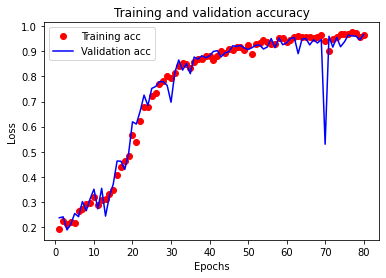

In [ ]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()